In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

In [27]:
from utils import load_mnist
from trainer import Trainer

In [28]:
class Autoencoder(nn.Module):
  def __init__(self,btl_size = 2):
    self.btl_size  = btl_size

    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28,500),
        nn.ReLU(),
        nn.BatchNorm1d(500),
        nn.Linear(500,200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50,20),
        nn.ReLU(),
        nn.BatchNorm1d(20),
        nn.Linear(20,10),
        nn.ReLU(),
        nn.BatchNorm1d(10),
        nn.Linear(10,btl_size),
    )

    self.decoder = nn.Sequential(
        nn.Linear(btl_size,10),
        nn.ReLU(),
        nn.BatchNorm1d(10),
        nn.Linear(10,20),
        nn.ReLU(),
        nn.BatchNorm1d(20),
        nn.Linear(20,50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50,100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100,200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200,500),
        nn.ReLU(),
        nn.BatchNorm1d(500),
        nn.Linear(500,28*28),
    )

  def forward(self,x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y

In [29]:
from argparse import Namespace

config = {
    'train_ratio' : .8,
    'batch_size' : 256,
    'n_epochs' : 50,
    'verbose' : 1,
    'btl_size' : 2
}

config = Namespace(**config)

print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [30]:
def show_image(x):
  if x.dim() == 1:
    x = x.view(int(x.size(0) ** .5) , -1)
  plt.imshow(x)
  plt.show()

In [31]:
train_x,train_y = load_mnist(flatten= True)
test_x,test_y = load_mnist(is_Train=False , flatten= True)
train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim = 0,
    index = indices
).split([train_cnt,valid_cnt], dim = 0)

train_y, valid_y = torch.index_select(
    train_y,
    dim = 0,
    index = indices
).split([train_cnt,valid_cnt], dim = 0)

print("Train:", train_x.shape, train_y.shape)
print("Valid", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [32]:
model = Autoencoder(btl_size= config.btl_size)
optimizer = optim.Adam(model.parameters())
crit  = nn.MSELoss()

trainer = Trainer(model, optimizer,crit)

In [33]:
trainer.train((train_x, train_x), (valid_x,valid_x), config)

Epoch(1/50): train_loss = 7.1108e-02 valid_loss = 4.8825e-02 lowest_loss = 4.8825e-02
Epoch(2/50): train_loss = 4.7674e-02 valid_loss = 4.5853e-02 lowest_loss = 4.5853e-02
Epoch(3/50): train_loss = 4.5368e-02 valid_loss = 4.4093e-02 lowest_loss = 4.4093e-02
Epoch(4/50): train_loss = 4.4169e-02 valid_loss = 4.4156e-02 lowest_loss = 4.4093e-02
Epoch(5/50): train_loss = 4.3520e-02 valid_loss = 4.1829e-02 lowest_loss = 4.1829e-02
Epoch(6/50): train_loss = 4.3136e-02 valid_loss = 4.1633e-02 lowest_loss = 4.1633e-02
Epoch(7/50): train_loss = 4.2450e-02 valid_loss = 4.2397e-02 lowest_loss = 4.1633e-02
Epoch(8/50): train_loss = 4.2100e-02 valid_loss = 4.0748e-02 lowest_loss = 4.0748e-02
Epoch(9/50): train_loss = 4.1902e-02 valid_loss = 4.0660e-02 lowest_loss = 4.0660e-02
Epoch(10/50): train_loss = 4.1184e-02 valid_loss = 4.0038e-02 lowest_loss = 4.0038e-02
Epoch(11/50): train_loss = 4.1027e-02 valid_loss = 4.0120e-02 lowest_loss = 4.0038e-02
Epoch(12/50): train_loss = 4.0966e-02 valid_loss = 3

7231


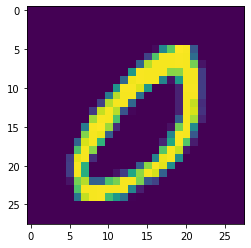

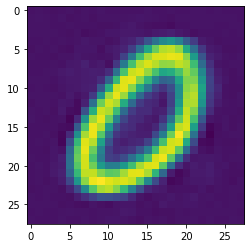

In [34]:
with torch.no_grad():
  import random
  index = int(random.random() * test_x.size(0))
  print(index)
  recon = model(test_x[index].view(1,-1)).squeeze()

  show_image(test_x[index])
  show_image(recon)

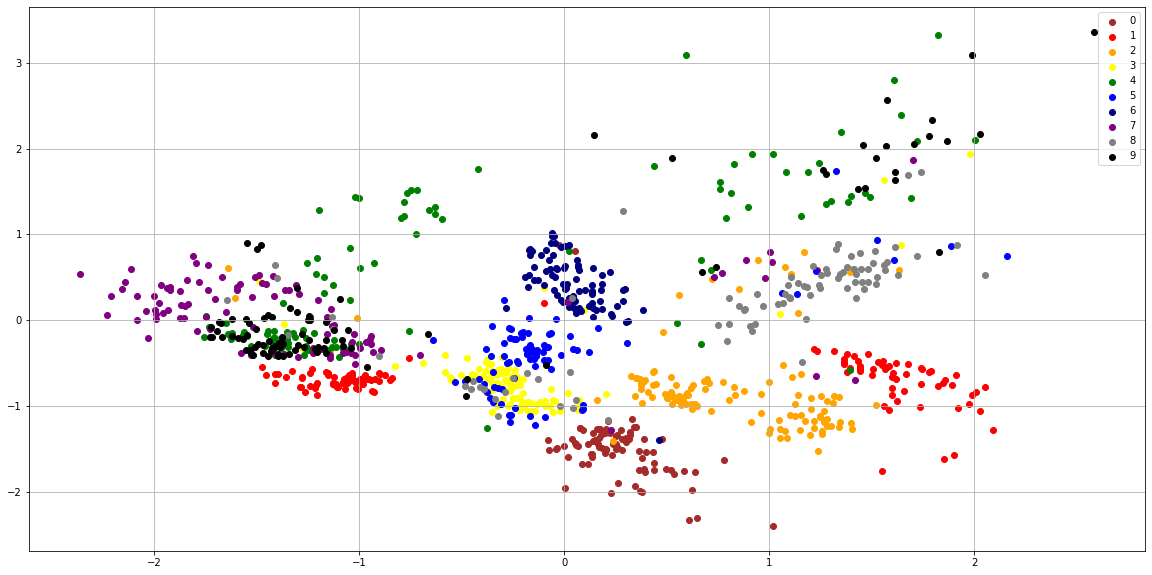

In [35]:
if config.btl_size == 2:
  color_map = ['brown','red','orange','yellow','green','blue','navy','purple','gray','black']

  plt.figure(figsize=(20,10,))

  with torch.no_grad():
    latents = model.encoder(test_x[:1000])

    for i in range(10):
      target_latents = latents[test_y[:1000] == i]
      target_y = test_y[:1000][test_y[:1000] == i]
      plt.scatter(
          target_latents[:, 0],
          target_latents[:,1],
          marker = 'o',
          color = color_map[i],
          label = i
      )
    plt.legend()
    plt.grid(axis = 'both')
    plt.show()

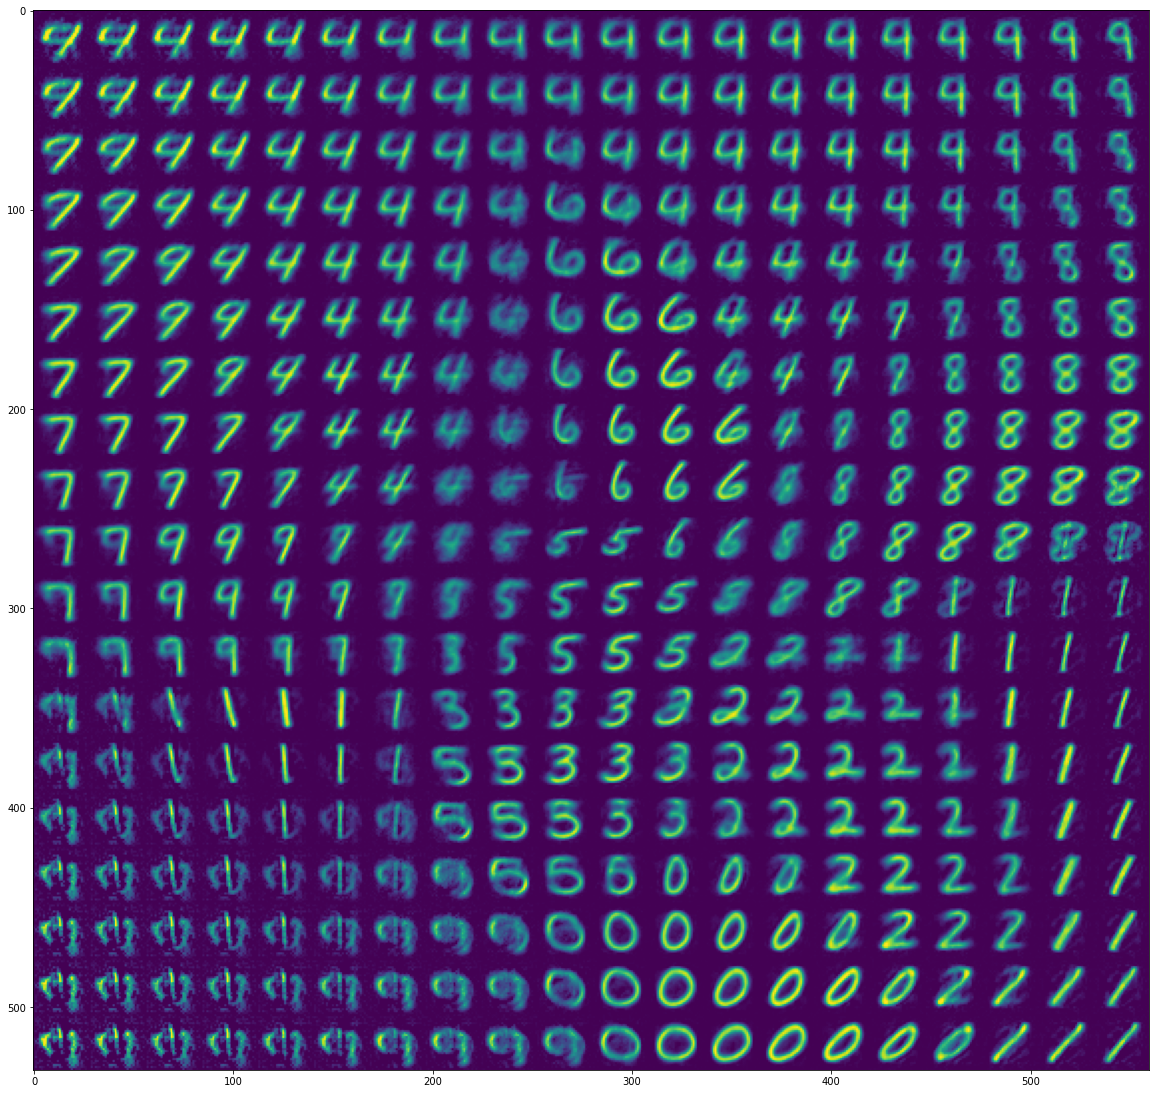

In [37]:
if config.btl_size == 2:
  min_range, max_range = -2., 2.
  n = 20
  step = (max_range - min_range) / float(n)

  with torch.no_grad():
    lines = []
    for v1 in np.arange(min_range, max_range, step):
      z = torch.stack([
                       torch.FloatTensor([v1] * n),
                       torch.FloatTensor([v2 for v2 in np.arange(min_range, max_range, step)]),]
      ,dim = -1)

      line = torch.clamp(model.decoder(z).view(n,28,28),0,1)
      line = torch.cat([line[i] for i in range(n -1, 0, -1)], dim = 0 )
      lines += [line]

    lines = torch.cat(lines, dim = -1)
    plt.figure(figsize = (20,20))
    show_image(lines)